<a href="https://colab.research.google.com/github/kopalgarg/time-series-forecasting/blob/main/time_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Hourly predictions of weather 

Setup - Import modules

In [4]:
import os
import datetime

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

Import the weather dataset: https://www.bgc-jena.mpg.de/wetter/

14 columns including air temperature, atm pressure, humidity, and more.

In [14]:
zip_path = tf.keras.utils.get_file(
    origin= 'https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname = 'jena_climate_2009_2016.csv.zip',
    extract = True
)

csv_path = os.path.splitext(zip_path)[0]

Dealing with hourly predictions, so subsample data from 10 min intervals to 1 h.

In [25]:
df = pd.read_csv(csv_path)
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


Start from index 5 and take every 6th record. Make a separate data frame for the date-time columns after reformatting it.

In [26]:
df = df[5::6]
date_time = pd.to_datetime(df.pop('Date Time'), format = '%d.%m.%Y %H:%M:%S')
date_time.head()

5    2009-01-01 01:00:00
11   2009-01-01 02:00:00
17   2009-01-01 03:00:00
23   2009-01-01 04:00:00
29   2009-01-01 05:00:00
Name: Date Time, dtype: datetime64[ns]

In [27]:
df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


Visualize features over time.

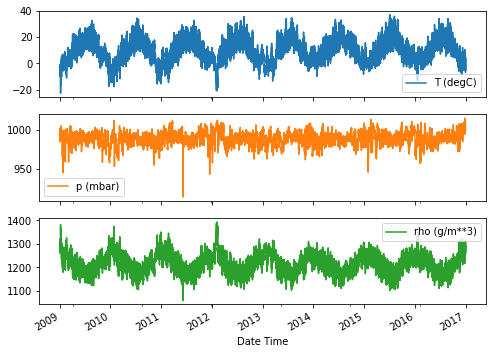

In [31]:
plot_features = df[['T (degC)', 'p (mbar)', 'rho (g/m**3)']]
plot_features.index = date_time 
p1 = plot_features.plot(subplots=True)

Zooming in

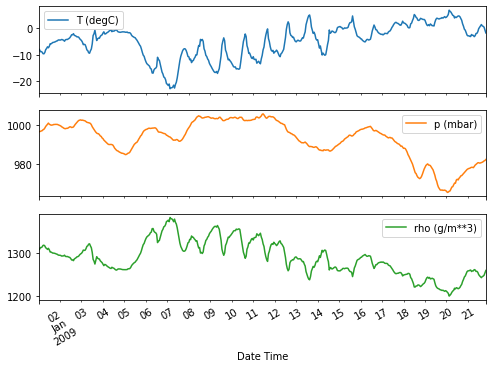

In [33]:
plot_features = df[['T (degC)', 'p (mbar)', 'rho (g/m**3)']][:500]
plot_features.index = date_time[:500]
p1 = plot_features.plot(subplots=True)

Summarize the data using mean, count, std, min, percentiles

In [36]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
p (mbar),70091.0,989.212842,8.358886,913.60,984.20,989.57,994.720,1015.29
T (degC),70091.0,9.450482,8.423384,-22.76,3.35,9.41,15.480,37.28
Tpot (K),70091.0,283.493086,8.504424,250.85,277.44,283.46,289.530,311.21
Tdew (degC),70091.0,4.956471,6.730081,-24.80,0.24,5.21,10.080,23.06
rh (%),70091.0,76.009788,16.474920,13.88,65.21,79.30,89.400,100.00
VPmax (mbar),70091.0,13.576576,7.739883,0.97,7.77,11.82,17.610,63.77
VPact (mbar),70091.0,9.533968,4.183658,0.81,6.22,8.86,12.360,28.25
VPdef (mbar),70091.0,4.042536,4.898549,0.00,0.87,2.19,5.300,46.01
sh (g/kg),70091.0,6.022560,2.655812,0.51,3.92,5.59,7.800,18.07
H2OC (mmol/mol),70091.0,9.640437,4.234862,0.81,6.29,8.96,12.490,28.74


Clean up (wind velocity has a negative value)

In [41]:
wv = df['wv (m/s)']
max_wv = df['max. wv (m/s)']

wv[wv==-9999.0] = 0.0
max_wv[max_wv==-9999.0] = 0.0

df['wv (m/s)'].min()
df['max. wv (m/s)'].min()

0.0

Feature engineering 